In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from src.features.feature_engineering_1 import *
from src.features.q3_plots import *
from sklearn.metrics import accuracy_score, confusion_matrix, recall_score, f1_score

In [2]:
import os
from dotenv import load_dotenv
from comet_ml import Experiment
load_dotenv('..\.env')

True

In [3]:
# Définition des années de train
years_train = ['2016', '2017', '2018', '2019']

In [4]:
# Chargement des données d'entrainement
data = get_all_season_data(years_train)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,x_coordinate,y_coordinate,empty_net,strength,last_event_type,last_event_x,last_event_y,time_since_last_event,distance_from_last_event
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,-77.0,5.0,NaN,NaN,Blocked Shot,-61.0,11.0,1,17.088007
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,86.0,13.0,NaN,NaN,Giveaway,54.0,-5.0,5,36.715120
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,23.0,-38.0,NaN,NaN,Missed Shot,-72.0,0.0,18,102.318131
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,33.0,-15.0,NaN,NaN,Missed Shot,77.0,-2.0,19,45.880279
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,-34.0,28.0,NaN,NaN,Hit,47.0,34.0,16,81.221918


In [5]:
# Ajout des features de distance et d'angle
data = add_new_features(data)
data.head()

,period,period_type,period_time,gameID,attacking_team_id,attacking_team_name,play_type,shooter,goalie,shot_type,...,strength,last_event_type,last_event_x,last_event_y,time_since_last_event,distance_from_last_event,distance_to_net,shot_angle,is_goal,is_empty_net
0,1,REGULAR,01:11,2016020001,10,Toronto Maple Leafs,Shot,Mitchell Marner,Craig Anderson,Wrist Shot,...,NaN,Blocked Shot,-61.0,11.0,1,17.088007,13.0,23.0,0,0
1,1,REGULAR,02:53,2016020001,9,Ottawa Senators,Shot,Chris Kelly,Frederik Andersen,Wrist Shot,...,NaN,Giveaway,54.0,-5.0,5,36.715120,13.0,77.0,0,0
2,1,REGULAR,04:01,2016020001,9,Ottawa Senators,Shot,Cody Ceci,Frederik Andersen,Wrist Shot,...,NaN,Missed Shot,-72.0,0.0,18,102.318131,76.0,-30.0,0,0
3,1,REGULAR,04:46,2016020001,9,Ottawa Senators,Shot,Erik Karlsson,Frederik Andersen,Slap Shot,...,NaN,Missed Shot,77.0,-2.0,19,45.880279,58.0,-15.0,0,0
4,1,REGULAR,06:46,2016020001,10,Toronto Maple Leafs,Shot,Martin Marincin,Craig Anderson,Wrist Shot,...,NaN,Hit,47.0,34.0,16,81.221918,62.0,27.0,0,0


In [6]:
# Sélection de la caractéristique distance_to_net et des labels is_goal
df1 = data[['distance_to_net', 'is_goal']]
df1.head()

,distance_to_net,is_goal
0,13.0,0
1,13.0,0
2,76.0,0
3,58.0,0
4,62.0,0


In [7]:
# Suppression des valeurs NaN
df1 = df1.dropna()

In [8]:
y1 = df1['is_goal'].values
X1 = df1['distance_to_net'].values

In [9]:
# Split des données d'entrainement en train et val
X_train1, X_val1, y_train1, y_val1 = train_test_split(X1, y1, test_size=0.2)

# Reshpae des array
X_train1 = X_train1.reshape(X_train1.shape[0], 1)
X_val1 = X_val1.reshape(X_val1.shape[0], 1)

**Question 1**

In [10]:
modele_base1 = LogisticRegression()
modele_base1.fit(X_train1, y_train1)

LogisticRegression()

In [11]:
# Prédiction des données de val
y_pred1 = modele_base1.predict(X_val1)

In [12]:
confusion_matrix(y_val1, y_pred1)

array([[59311,     0],
       [ 6154,     0]], dtype=int64)

In [13]:
accuracy1 = accuracy_score(y_val1, modele_base1.predict(X_val1))
recall1 = recall_score(y_val1, modele_base1.predict(X_val1))
f1_score1 = f1_score(y_val1, modele_base1.predict(X_val1))
auc1 = roc_auc_score(y_val1, modele_base1.predict_proba(X_val1)[:, 1])

print('Accuracy :', accuracy1)
print('Recall :', recall1)
print('Recall :', f1_score1)
print('AUC :', auc1)

Accuracy : 0.9059955701519896
Recall : 0.0
Recall : 0.0
AUC : 0.6927882066727394


Nous remarquons que la précision du modèle est très bonne. Cependant ce résultat est trompeur car le modèle prédit que tous les exemples de l'ensemble de validation sont de la classe 0 (à l'aide de la matrice de confusion)

En calculant le Recall on se rend compte qu'il vaut 0. C'est un très très mauvais résultat.

Les problèmes possibles sont :
- Pas assez d'exemple de la classe 1 (pour un but)
- Seul la distance ne suffit pas pour prédire correctement 

**Question 2**

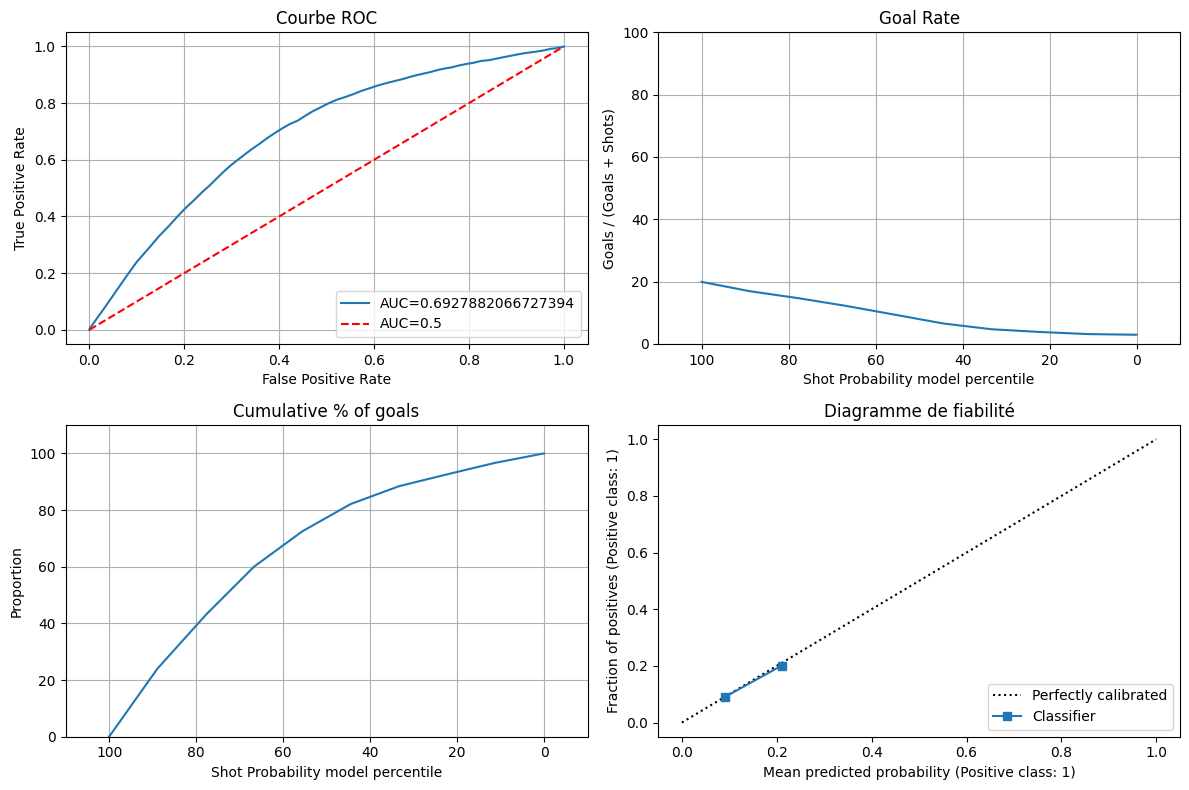

In [14]:
y_pred_proba1 = modele_base1.predict_proba(X_val1)[:, 1]
plot_metrics(y_val1, y_pred_proba1)

$\textbf{Expérience 1: en utilisant la distance}$

In [15]:
experiment1 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment1.set_name("modele_base with distance")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tedoul/ift6758-project/52b411393e5f466fa43672969dce1fd8



In [16]:
#charger les métriques que vous avez calculé
experiment1.log_metrics({"accuracy": accuracy1, "recall": recall1, "f1-score": f1_score1, "auc": auc1})
experiment1.log_confusion_matrix(y_val1, modele_base1.predict(X_val1))

{'web': 'https://www.comet.com/api/asset/download?assetId=add9e38b37b641c29e9db021b8369c65&experimentKey=52b411393e5f466fa43672969dce1fd8',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=add9e38b37b641c29e9db021b8369c65&experimentKey=52b411393e5f466fa43672969dce1fd8',
 'assetId': 'add9e38b37b641c29e9db021b8369c65'}

In [17]:
experiment1.log_figure(figure=plot_roc_curve(y_val1, y_pred_proba1), figure_name="Courbe ROC")
plt.close()
experiment1.log_figure(figure=plot_goal_rate(y_val1, y_pred_proba1), figure_name="Goal rate")
plt.close()
experiment1.log_figure(figure=plot_cumulative_percent_goal(y_val1, y_pred_proba1), figure_name="Cumulative percent of goal")
plt.close()
experiment1.log_figure(figure=plot_fiability_diagram_resize(y_val1, y_pred_proba1), figure_name="Diagrame de fiabilité")
plt.close()


In [18]:
experiment1.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x0000019069B15FD0>>

**Question 3**

Utilisation de la caractéristique d'angle uniquement

In [19]:
#utilisation de la caractéristique d'angle
df2 = data[['shot_angle', 'is_goal']]
df2 = df2.dropna()
df2.head()

,shot_angle,is_goal
0,23.0,0
1,77.0,0
2,-30.0,0
3,-15.0,0
4,27.0,0


In [20]:
y2 = df2['is_goal'].values
X2 = df2['shot_angle'].values

# Split des données d'entrainement en train et val
X_train2, X_val2, y_train2, y_val2 = train_test_split(X2, y2, test_size=0.2)

# Reshpae des array
X_train2 = X_train2.reshape(X_train2.shape[0], 1)
X_val2 = X_val2.reshape(X_val2.shape[0], 1)

In [21]:
modele_base2 = LogisticRegression()
modele_base2.fit(X_train2, y_train2)

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


LogisticRegression()

In [22]:
accuracy2 = accuracy_score(y_val2, modele_base2.predict(X_val2))
recall2 = recall_score(y_val2, modele_base2.predict(X_val2))
f1_score2 = f1_score(y_val2, modele_base1.predict(X_val2))
auc2 = roc_auc_score(y_val2, modele_base2.predict_proba(X_val2)[:, 1])

print('Accuracy :', accuracy2)
print('Recall :', recall2)
print('Recall :', f1_score2)
print('AUC :', auc2)

Accuracy : 0.9047429924387077
Recall : 0.0
Recall : 0.12054684358665059
AUC : 0.5024825366879518


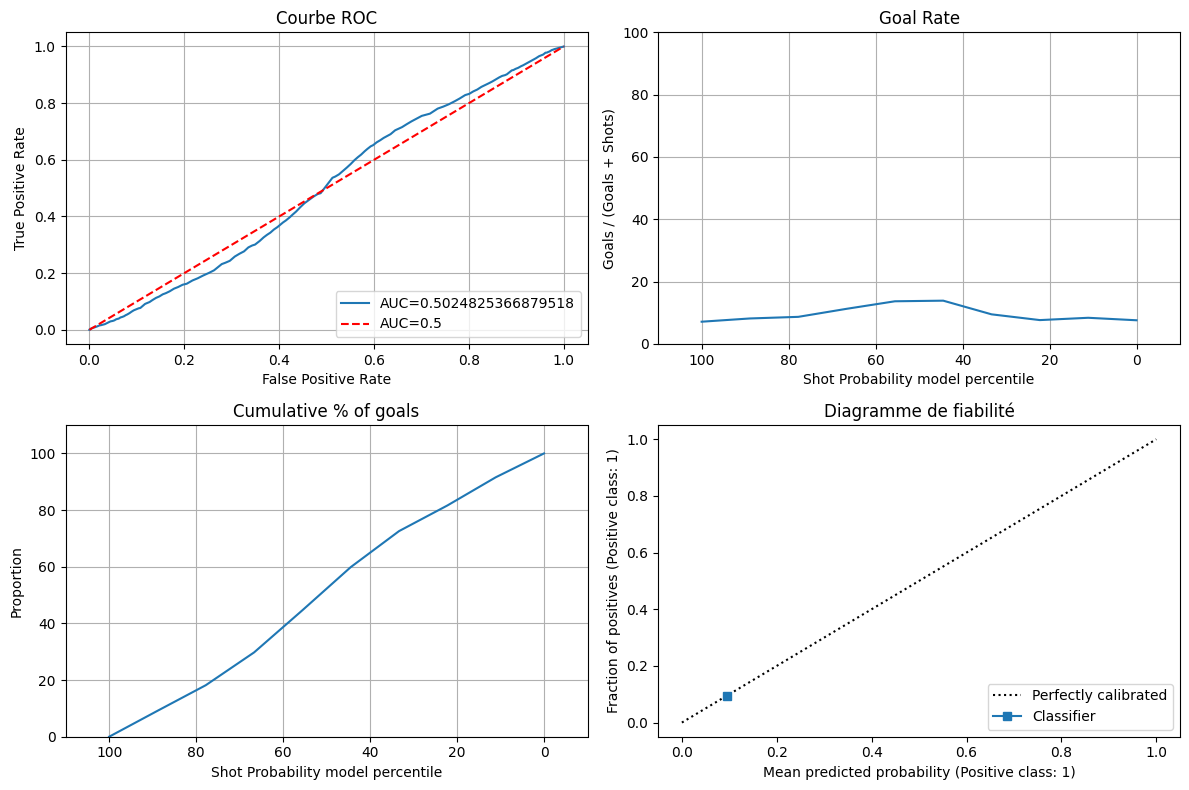

In [23]:
y_pred_proba2 = modele_base2.predict_proba(X_val2)[:, 1]
plot_metrics(y_val2, y_pred_proba2)

$\textbf{Expérience 2: Utilisation de l'angle}$

In [24]:
experiment2 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment2.set_name("modele_base with angle")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/52b411393e5f466fa43672969dce1fd8
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9059955701519896
COMET INFO:     auc      : 0.6927882066727394
COMET INFO:     f1-score : 0.0
COMET INFO:     recall   : 0.0
COMET INFO:   Others:
COMET INFO:     Name : modele_base with distance
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git m

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tedoul/ift6758-project/2851a7f0e36a4974aa702f647a551435



In [25]:
#charger les métriques que vous avez calculé
experiment2.log_metrics({"accuracy": accuracy2, "recall": recall2, "f1-score": f1_score2, "auc": auc2})
experiment2.log_confusion_matrix(y_val2, modele_base2.predict(X_val2))

{'web': 'https://www.comet.com/api/asset/download?assetId=b42b5cc6ccbf4f0bb18c9d18117d9d27&experimentKey=2851a7f0e36a4974aa702f647a551435',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=b42b5cc6ccbf4f0bb18c9d18117d9d27&experimentKey=2851a7f0e36a4974aa702f647a551435',
 'assetId': 'b42b5cc6ccbf4f0bb18c9d18117d9d27'}

In [26]:
experiment2.log_figure(figure=plot_roc_curve(y_val2, y_pred_proba2), figure_name="Courbe ROC")
plt.close()
experiment2.log_figure(figure=plot_goal_rate(y_val2, y_pred_proba2), figure_name="Goal rate")
plt.close()
experiment2.log_figure(figure=plot_cumulative_percent_goal(y_val2, y_pred_proba2), figure_name="Cumulative percent of goal")
plt.close()
experiment2.log_figure(figure=plot_fiability_diagram_resize(y_val2, y_pred_proba2), figure_name="Diagrame de fiabilité")
plt.close()


COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [27]:
experiment2.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x000001906255C670>>

Utilisation de la caractéristique d'angle et distance

In [28]:
#utilisation de la caractéristique d'angle
df3 = data[['distance_to_net', 'shot_angle', 'is_goal']]
df3 = df3.dropna()
df3.head()

,distance_to_net,shot_angle,is_goal
0,13.0,23.0,0
1,13.0,77.0,0
2,76.0,-30.0,0
3,58.0,-15.0,0
4,62.0,27.0,0


In [29]:
y3 = df3['is_goal'].values
X3 = df3[['distance_to_net', 'shot_angle']].values

# Split des données d'entrainement en train et val
X_train3, X_val3, y_train3, y_val3 = train_test_split(X3, y3, test_size=0.2)

In [30]:
modele_base3 = LogisticRegression()
modele_base3.fit(X_train3, y_train3)

LogisticRegression()

In [31]:
accuracy3 = accuracy_score(y_val3, modele_base3.predict(X_val3))
recall3 = recall_score(y_val3, modele_base3.predict(X_val3))
f1_score3 = f1_score(y_val3, modele_base3.predict(X_val3))
auc3 = roc_auc_score(y_val3, modele_base3.predict_proba(X_val3)[:, 1])

print('Accuracy :', accuracy3)
print('Recall :', recall3)
print('Recall :', f1_score3)
print('AUC :', auc3)

Accuracy : 0.9068357137401665
Recall : 0.0
Recall : 0.0
AUC : 0.6986009493317034


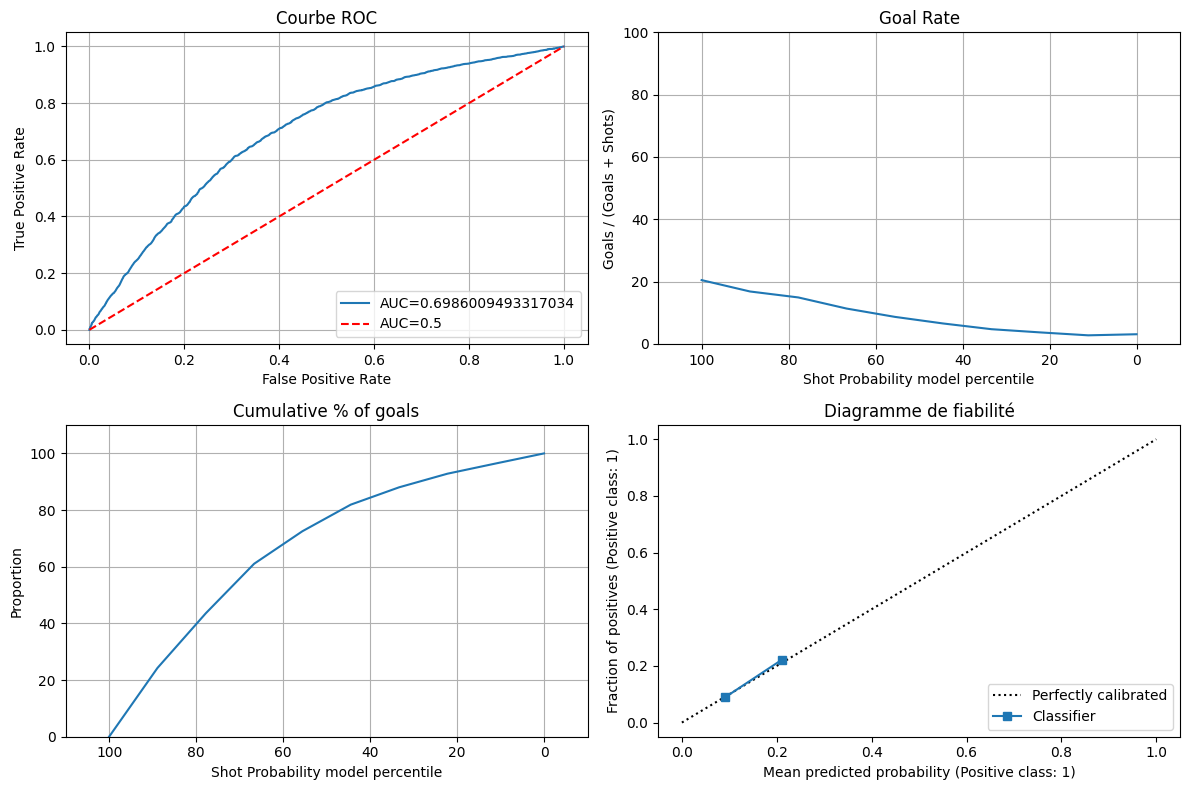

In [32]:
y_pred_proba3 = modele_base3.predict_proba(X_val3)[:, 1]
plot_metrics(y_val3, y_pred_proba3)

$\textbf{Expérience 3: Utilisation de la distance + l'angle}$

In [33]:
experiment3 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment3.set_name("modele_base with distance and angle")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/2851a7f0e36a4974aa702f647a551435
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9047429924387077
COMET INFO:     auc      : 0.5024825366879518
COMET INFO:     f1-score : 0.12054684358665059
COMET INFO:     recall   : 0.0
COMET INFO:   Others:
COMET INFO:     Name : modele_base with angle
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET IN

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET WARNING: As you are running in a Jupyter environment, you will need to call `experiment.end()` when finished to ensure all metrics and code are logged before exiting.
COMET INFO: Experiment is live on comet.com https://www.comet.com/tedoul/ift6758-project/34d5caaf5be146bfbd998a50cf387d53



In [34]:
#charger les métriques que vous avez calculé
experiment3.log_metrics({"accuracy": accuracy3, "recall": recall3, "f1-score": f1_score3, "auc": auc3})
experiment3.log_confusion_matrix(y_val3, modele_base3.predict(X_val3))

{'web': 'https://www.comet.com/api/asset/download?assetId=ce5075c8fe114686ada6ff56f7d4c6e4&experimentKey=34d5caaf5be146bfbd998a50cf387d53',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=ce5075c8fe114686ada6ff56f7d4c6e4&experimentKey=34d5caaf5be146bfbd998a50cf387d53',
 'assetId': 'ce5075c8fe114686ada6ff56f7d4c6e4'}

In [35]:
experiment3.log_figure(figure=plot_roc_curve(y_val3, y_pred_proba3), figure_name="Courbe ROC")
plt.close()
experiment3.log_figure(figure=plot_goal_rate(y_val3, y_pred_proba3), figure_name="Goal rate")
plt.close()
experiment3.log_figure(figure=plot_cumulative_percent_goal(y_val3, y_pred_proba3), figure_name="Cumulative percent of goal")
plt.close()
experiment3.log_figure(figure=plot_fiability_diagram_resize(y_val3, y_pred_proba3), figure_name="Diagrame de fiabilité")
plt.close()


COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [36]:
experiment3.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x0000019066E92190>>

$\textbf{Ligne de base aléatoire}$

In [37]:
random_proba = np.random.uniform(0, 1, len(y_val3))

In [38]:
y_pred_proba4 = (random_proba > 0.5) * 1
print(accuracy_score(y_val3, y_pred_proba4))

0.49858703123806614


In [39]:
accuracy4 = accuracy_score(y_val3, y_pred_proba4)
recall4 = recall_score(y_val3, y_pred_proba4)
f1_score4 = f1_score(y_val3, y_pred_proba4)
auc4 = roc_auc_score(y_val3, random_proba)

print('Accuracy :', accuracy4)
print('Recall :', recall4)
print('Recall :', f1_score4)
print('AUC :', auc4)

Accuracy : 0.49858703123806614
Recall : 0.48762092146253483
Recall : 0.15340572047558867
AUC : 0.49452629519695457


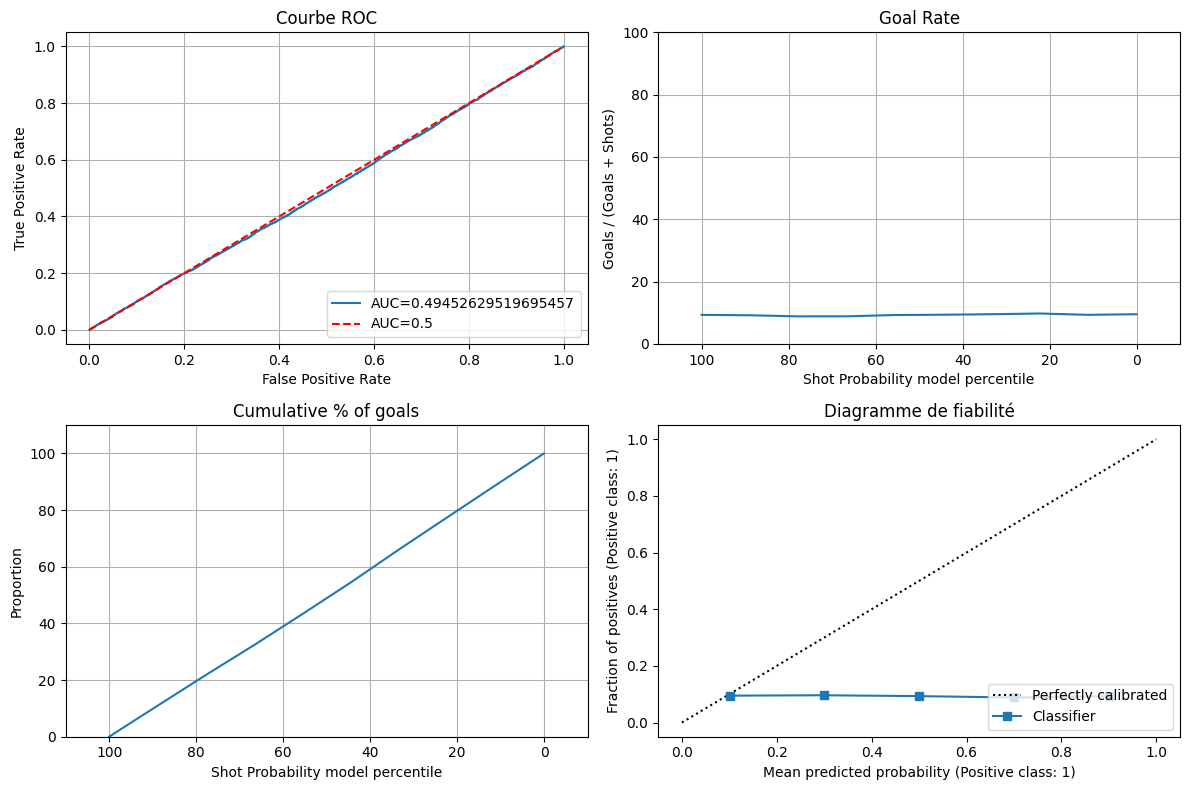

In [40]:
plot_metrics(y_val3, random_proba)

$\textbf{Expérience 4: Random baseline}$

In [41]:
experiment4 = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

#nommer l'expérience
experiment4.set_name("random baseline")

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/34d5caaf5be146bfbd998a50cf387d53
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.9068357137401665
COMET INFO:     auc      : 0.6986009493317034
COMET INFO:     f1-score : 0.0
COMET INFO:     recall   : 0.0
COMET INFO:   Others:
COMET INFO:     Name : modele_base with distance and angle
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:

In [42]:
#charger les métriques que vous avez calculé
experiment4.log_metrics({"accuracy": accuracy4, "recall": recall4, "f1-score": f1_score4, "auc": auc4})
experiment4.log_confusion_matrix(y_val3, y_pred_proba4)

{'web': 'https://www.comet.com/api/asset/download?assetId=52c9cf5042474024b610a54fdd864324&experimentKey=d853639b565e4423a57988bbad78bfb3',
 'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=52c9cf5042474024b610a54fdd864324&experimentKey=d853639b565e4423a57988bbad78bfb3',
 'assetId': '52c9cf5042474024b610a54fdd864324'}

In [43]:
experiment4.log_figure(figure=plot_roc_curve(y_val3, random_proba), figure_name="Courbe ROC")
plt.close()
experiment4.log_figure(figure=plot_goal_rate(y_val3, random_proba), figure_name="Goal rate")
plt.close()
experiment4.log_figure(figure=plot_cumulative_percent_goal(y_val3, random_proba), figure_name="Cumulative percent of goal")
plt.close()
experiment4.log_figure(figure=plot_fiability_diagram_resize(y_val3, random_proba), figure_name="Diagrame de fiabilité")
plt.close()

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information


In [44]:
experiment4.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x0000019064821B80>>

$\text{Superposition de toutes les courbes}$

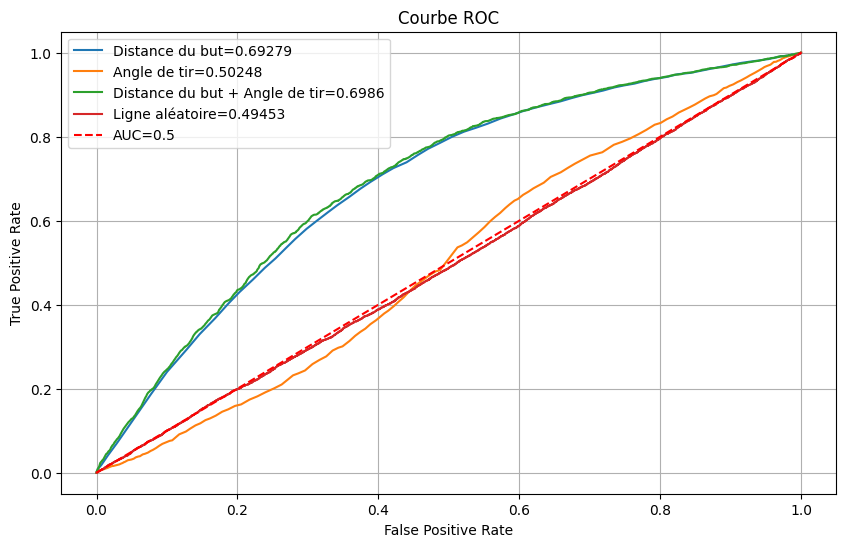

In [45]:
list_y_val = [y_val1, y_val2, y_val3, y_val3]
list_y_proba = [y_pred_proba1, y_pred_proba2, y_pred_proba3, random_proba]
models = ['Distance du but', 'Angle de tir', 'Distance du but + Angle de tir', 'Ligne aléatoire']

plot_all_roc_curve(list_y_val, list_y_proba, models)

Plus l'AUC est proche de 1, meilleure est la performance du modèle. Dans ce cas en utilisant à la fois les caractéristiques de distance et d'angle, le modèle entrainé est le plus performant que si on l'avait entrainé en utilisant soit la distance soit l'angle.

Toutefois nous remarquons qu'en utilisant seulement la caractéristique de distance, les performances du modèle sont meilleures comparé au modèle entrainé en utilisant seulement la caractéristique d'angle. On pourrait conclure que la distance du but est une caractéristique plus importante que celle de l'angle de tir.

Quand on tire uniformément les probabilité de but, l'AUC est proche de 0.5 ce qui équivaut à prédire au hasard s'il y a but ou pas.

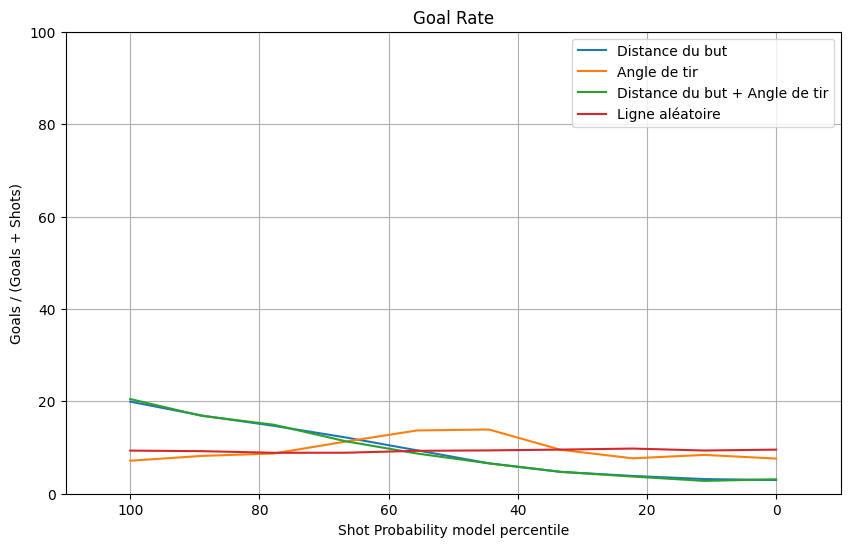

In [46]:
plot_all_goal_rate(list_y_val, list_y_proba, models)

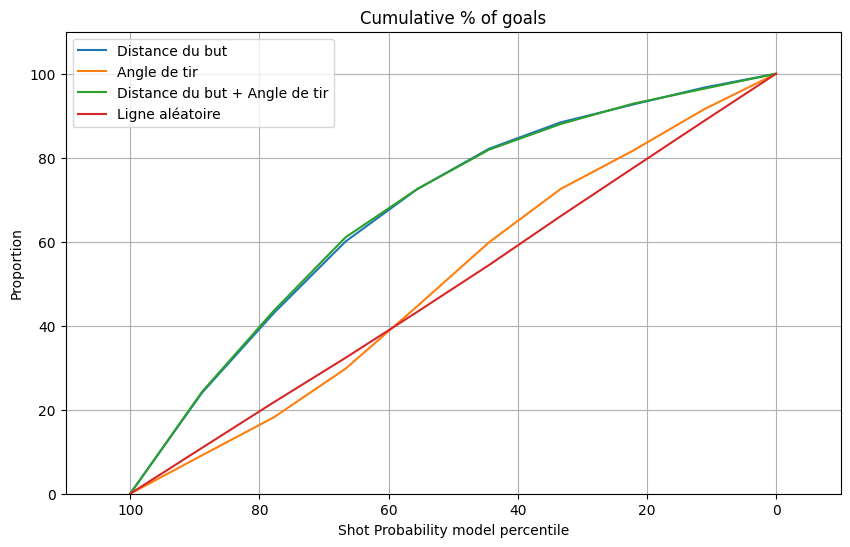

In [47]:
plot_all_cumulative_percent_goal(list_y_val, list_y_proba, models)

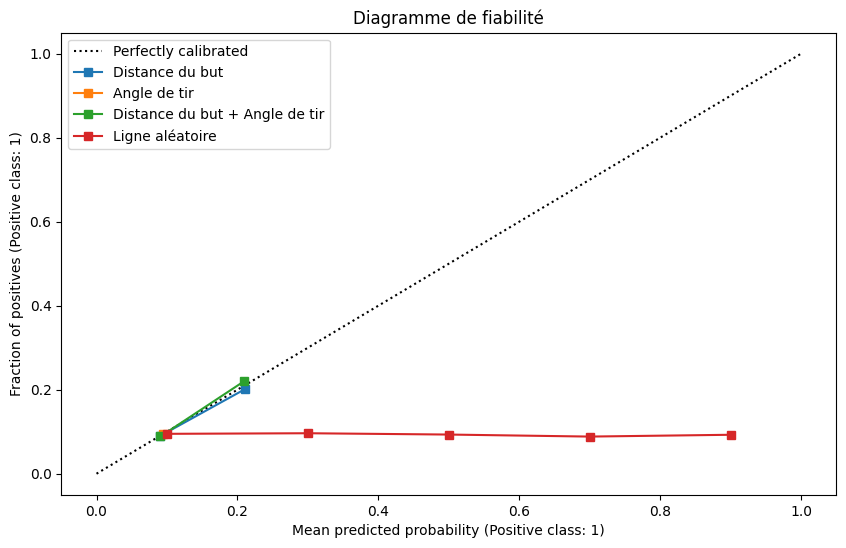

In [48]:
plot_all_fiability_diagram(list_y_val, list_y_proba, models)

$\textbf{Question 4-5}$

In [49]:
data_2017021065 = pd.read_csv('..\data\datasets\csv_files\\2017021065.csv')

In [50]:
experiment = Experiment(
    api_key = os.getenv('COMET_API_KEY'),
    project_name="ift6758-project",
    workspace="tedoul",
)

experiment.set_name('wpg_v_wsh_2017021065')

COMET WARNING: To get all data logged automatically, import comet_ml before the following modules: sklearn.


COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO: Comet.ml Experiment Summary
COMET INFO: ---------------------------------------------------------------------------------------
COMET INFO:   Data:
COMET INFO:     display_summary_level : 1
COMET INFO:     url                   : https://www.comet.com/tedoul/ift6758-project/d853639b565e4423a57988bbad78bfb3
COMET INFO:   Metrics:
COMET INFO:     accuracy : 0.49858703123806614
COMET INFO:     auc      : 0.49452629519695457
COMET INFO:     f1-score : 0.15340572047558867
COMET INFO:     recall   : 0.48762092146253483
COMET INFO:   Others:
COMET INFO:     Name : random baseline
COMET INFO:   Uploads:
COMET INFO:     confusion-matrix         : 1
COMET INFO:     environment details      : 1
COMET INFO:     figures                  : 4
COMET INFO:     filename                 : 1
COMET INFO:     git metadata             : 1
COMET INFO:     git-patch (uncompressed) : 1 (1.68 MB)
COMET

In [51]:
experiment.log_dataframe_profile(
data_2017021065, 
name='wpg_v_wsh_2017021065',  # keep this name
dataframe_format='csv'  # ensure you set this flag!
)


COMET WARNING: pandas_profiling is required to log profile; ignoring


{'profile': None,
 'dataframe': {'web': 'https://www.comet.com/api/asset/download?assetId=53cb66b6c8d540768dd05aa26897d6a6&experimentKey=3e5fc306a04d4b02aa3c7b837ccb9f0d',
  'api': 'https://www.comet.com/api/rest/v2/experiment/asset/get-asset?assetId=53cb66b6c8d540768dd05aa26897d6a6&experimentKey=3e5fc306a04d4b02aa3c7b837ccb9f0d',
  'assetId': '53cb66b6c8d540768dd05aa26897d6a6'}}

In [ ]:
experiment.end

<bound method BaseExperiment.end of <comet_ml._online.Experiment object at 0x000001906444AB50>>

COMET WARNING: Unknown error exporting current conda environment
COMET WARNING: Unknown error retrieving Conda package as an explicit file
COMET WARNING: Unknown error retrieving Conda information
